In [7]:
import os
import os.path as op
import xarray as xr
import numpy as np
import geopandas as gpd
from datetime import datetime
import calendar
import pandas
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Point

dirData = 'C:\\Users\\aag23\OneDrive - UNICAN - Estudiantes\CicloDeVidadelosDatos\TrabajoEnGrupo\datos\Precipitacion'
fileDataRaw = 'precipitation_spain_raw.nc'
# Abrimos el fichero y lo cargamos en un objeto de tipo Dataset
data = xr.open_dataset(op.join(dirData, fileDataRaw))
# Mostramos la estructura del fichero
print(data)

<xarray.Dataset> Size: 25MB
Dimensions:  (time: 551, lat: 81, lon: 141)
Coordinates:
  * time     (time) datetime64[ns] 4kB 1979-01-01T06:00:00 ... 2024-11-01T06:...
  * lat      (lat) float64 648B 45.0 44.75 44.5 44.25 ... 25.75 25.5 25.25 25.0
  * lon      (lon) float64 1kB -30.0 -29.75 -29.5 -29.25 ... 4.25 4.5 4.75 5.0
Data variables:
    tp       (time, lat, lon) float32 25MB ...
Attributes:
    CDI:          Climate Data Interface version 2.0.4 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      Thu Jan 02 12:30:13 2025: cdo -f nc copy /mnt/c/Users/aag23...
    CDO:          Climate Data Operators version 2.0.4 (https://mpimet.mpg.de...


<>:6: SyntaxWarning: invalid escape sequence '\O'
<>:6: SyntaxWarning: invalid escape sequence '\O'
C:\Users\aag23\AppData\Local\Temp\ipykernel_20560\3461040251.py:6: SyntaxWarning: invalid escape sequence '\O'
  dirData = 'C:\\Users\\aag23\OneDrive - UNICAN - Estudiantes\CicloDeVidadelosDatos\TrabajoEnGrupo\datos\Precipitacion'


   id   name                  source  \
0  ES  Spain  https://simplemaps.com   

                                            geometry  
0  MULTIPOLYGON (((-5.34073 35.84736, -5.3629 35....  


<>:5: SyntaxWarning: invalid escape sequence '\O'
<>:5: SyntaxWarning: invalid escape sequence '\O'
C:\Users\aag23\AppData\Local\Temp\ipykernel_20560\1587961571.py:5: SyntaxWarning: invalid escape sequence '\O'
  dirShape = 'C:\\Users\\aag23\OneDrive - UNICAN - Estudiantes\CicloDeVidadelosDatos\TrabajoEnGrupo\scripts\shapes\es_shp'


<Axes: >

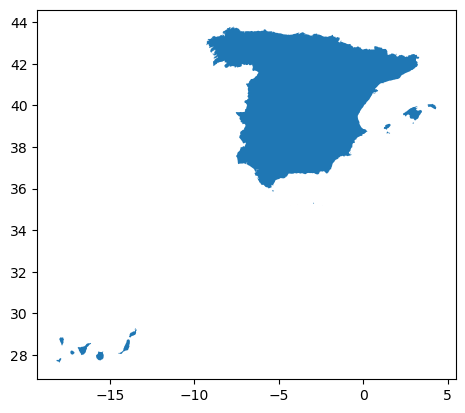

In [10]:
# load a shape file with the limits of Spain
dirShape = 'C:\\Users\\aag23\OneDrive - UNICAN - Estudiantes\CicloDeVidadelosDatos\TrabajoEnGrupo\scripts\shapes\es_shp'
gdf = gpd.read_file(dirShape)
print(gdf)
# plot the shape
gdf.plot()


In [ ]:
# El data tiene la siguiente estructura
#Dimensions:  (time: 551, lat: 81, lon: 141)
#Coordinates:
#  * time     (time) datetime64[ns] 4kB 1979-01-01T06:00:00 ... 2024-11-01T06:...
#  * lat      (lat) float64 648B 45.0 44.75 44.5 44.25 ... 25.75 25.5 25.25 25.0
#  * lon      (lon) float64 1kB -30.0 -29.75 -29.5 -29.25 ... 4.25 4.5 4.75 5.0
#Data variables:
#    tp       (time, lat, lon) float32 

# vemos que puntos caen dentro del poligono con los limites de España
lon_points = data.lon.values
lat_points = data.lat.values
# hacemos un meshgrid con los puntos para obtener todas las combinaciones de puntos
# en forma de matriz
lon_points, lat_points = np.meshgrid(lon_points, lat_points)
# pasamos las matrices a vectores
lon_points = lon_points.flatten()
lat_points = lat_points.flatten()

# Recorremos ca da punto y vemos si cae dentro del poligono
# si cae dentro del poligono extraemos el valor de precipitación
# y lo guardamos en un array junto con las coordenadas del punto

# inicializamos los arrays donde guardaremos las coordenadas y los 
# valores de precipitación de los puntos que caen dentro del poligono
precipitation = np.array([])
lon = np.array([])
lat = np.array([])
for i in range(len(lon_points)):
    # creamos un objeto de tipo Point con las coordenadas del punto
    point = Point(lon_points[i], lat_points[i])
    # si el punto cae dentro del poligono
    if gdf.geometry.contains(point).values[0]:
        # localizamos los indices de lat y lon
        # para obtener el valor de precipitación
        # en el punto
        lat_idx = np.where(data.lat.values == lat_points[i])[0][0]
        lon_idx = np.where(data.lon.values == lon_points[i])[0][0]
        precipitation = np.append(precipitation, data.tp.values[:, lat_idx, lon_idx], axis=0)        
        # guardamos las coordenadas del punto
        lon = np.append(lon, lon_points[i])
        lat = np.append(lat, lat_points[i])
precipitation = precipitation.reshape(len(lon), len(data.time))
print(precipitation.shape)
# Los datos de precipitación están en m day-1 y los queremos en mm mes-1
# para ello multiplicamos el valor medio mensulta en m day-1 por el número de días
# que tiene el mes y lo pasamos a mm
# para cada mes

precipitation_mm = np.array([])
for i in range(len(data.time.values)):
    # creamos un objeto de tipo datetime con la fecha
    date = data.time.values.astype('M8[ms]').astype(datetime)[i]
    #date = data.time.values[i]
    # obtenemos el mes
    year = date.year
    month = date.month
    #print(year, month)
    # obtenemos el número de días que tiene el mes
    days = calendar.monthrange(year, month)[1]
    # pasamos la precipitación de m day-1 a mm mes-1
    precipitation_mm = np.append(precipitation_mm, precipitation[:, i]*days*1000)
precipitation_mm = precipitation_mm.reshape(len(data.time), len(lat))
print(precipitation_mm.shape)
# sumamos los valores de precipitación en el tiempo por años
# numero de años por el data.time
years = np.unique(data.time.dt.year)
total_precipitation_year = np.zeros([len(lon),len(years)])
for i in range(len(lon)):
    for j in range(len(years)):
        idx = np.where(data.time.dt.year == years[j])[0]
        total_precipitation_year[i,j] = np.sum(precipitation_mm[idx,i])

(861, 551)
(551, 861)


In [12]:
def calculate_total_precipitation(data, gdf):
    lon_points = data.lon.values
    lat_points = data.lat.values
    lon_points, lat_points = np.meshgrid(lon_points, lat_points)
    lon_points = lon_points.flatten()
    lat_points = lat_points.flatten()

    precipitation = np.array([])
    lon = np.array([])
    lat = np.array([])
    for i in range(len(lon_points)):
        point = Point(lon_points[i], lat_points[i])
        if gdf.geometry.contains(point).values[0]:
            lat_idx = np.where(data.lat.values == lat_points[i])[0][0]
            lon_idx = np.where(data.lon.values == lon_points[i])[0][0]
            precipitation = np.append(precipitation, data.tp.values[:, lat_idx, lon_idx], axis=0)
            lon = np.append(lon, lon_points[i])
            lat = np.append(lat, lat_points[i])
    precipitation = precipitation.reshape(len(lon), len(data.time))

    precipitation_mm = np.array([])
    for i in range(len(data.time.values)):
        date = data.time.values.astype('M8[ms]').astype(datetime)[i]
        year = date.year
        month = date.month
        days = calendar.monthrange(year, month)[1]
        precipitation_mm = np.append(precipitation_mm, precipitation[:, i] * days * 1000)
    precipitation_mm = precipitation_mm.reshape(len(data.time), len(lat))

    years = np.unique(data.time.dt.year)
    total_precipitation_year = np.zeros([len(lon), len(years)])
    for i in range(len(lon)):
        for j in range(len(years)):
            idx = np.where(data.time.dt.year == years[j])[0]
            total_precipitation_year[i, j] = np.sum(precipitation_mm[idx, i])
    # return total_precipitation_year and the coordinates of the points
    return total_precipitation_year, lon, lat


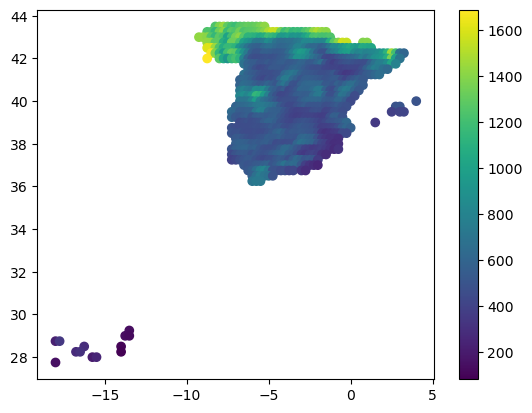

    time  precipitation
0   1979     808.590296
1   1980     606.312189
2   1981     614.098054
3   1982     649.523259
4   1983     616.696525
5   1984     728.397192
6   1985     648.336210
7   1986     635.664283
8   1987     757.469691
9   1988     659.332800
10  1989     772.282736
11  1990     568.876922
12  1991     587.308710
13  1992     604.400221
14  1993     612.088373
15  1994     524.662568
16  1995     590.341660
17  1996     857.034938
18  1997     809.624412
19  1998     555.478553
20  1999     624.336257
21  2000     661.607390
22  2001     651.341612
23  2002     694.688564
24  2003     749.870808
25  2004     597.072651
26  2005     477.902744
27  2006     663.738319
28  2007     582.660152
29  2008     713.785025
30  2009     649.251421
31  2010     816.754779
32  2011     575.964647
33  2012     577.809811
34  2013     738.369498
35  2014     715.482907
36  2015     546.391415
37  2016     710.010608
38  2017     499.256511
39  2018     835.292185
40  2019     628

In [15]:

total_precipitation_year, lon, lat = calculate_total_precipitation(data, gdf)
plt.scatter(lon, lat, c=total_precipitation_year.mean(axis=1), cmap='viridis')
plt.colorbar()
plt.show()

# Creamos un pandas DataFrame con el tiempo y la media de precipitación en España
# por año

precipitation_mean = np.mean(total_precipitation_year, axis=0)
data_serie = {'time': years, 'precipitation': precipitation_mean}
df = pd.DataFrame(data_serie)
print(df)
# Guardamos el DataFrame en un fichero csv en dirData
df.to_csv(op.join(dirData, 'precipitation_mean_Spain.csv'), index=False)
print(data_serie['precipitation'].mean())


      id                         name                  source  \
0   ESNC  Navarra, Comunidad Foral de  https://simplemaps.com   
1   ESPV                  PaÃ­s Vasco  https://simplemaps.com   
2   ESRI                     La Rioja  https://simplemaps.com   
3   ESCT                    CataluÃ±a  https://simplemaps.com   
4   ESAR                       Aragon  https://simplemaps.com   
5   ESEX                  Extremadura  https://simplemaps.com   
6   ESGA                      Galicia  https://simplemaps.com   
7   ESCL             Castilla y LeÃ³n  https://simplemaps.com   
8   ESVC         Comunidad Valenciana  https://simplemaps.com   
9   ESMC                       Murcia  https://simplemaps.com   
10  ESAN                   AndalucÃ­a  https://simplemaps.com   
11  ESAS                     Asturias  https://simplemaps.com   
12  ESCB                    Cantabria  https://simplemaps.com   
13  ESCN               Islas Canarias  https://simplemaps.com   
14  ESIB               Is

<>:1: SyntaxWarning: invalid escape sequence '\O'
<>:1: SyntaxWarning: invalid escape sequence '\O'
C:\Users\aag23\AppData\Local\Temp\ipykernel_29572\3377040304.py:1: SyntaxWarning: invalid escape sequence '\O'
  dir_shape = 'C:\\Users\\aag23\OneDrive - UNICAN - Estudiantes\CicloDeVidadelosDatos\TrabajoEnGrupo\scripts\shapes\CCAA_shp'


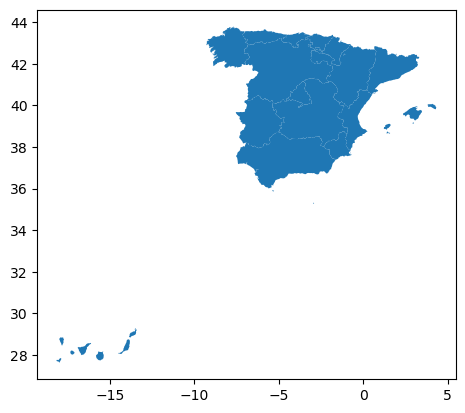

In [ ]:
dir_shape = 'C:\\Users\\aag23\OneDrive - UNICAN - Estudiantes\CicloDeVidadelosDatos\TrabajoEnGrupo\scripts\shapes\CCAA_shp'
gdf_all = gpd.read_file(dir_shape)
print(gdf)
# plot the shape
gdf_all.plot()
info_ccaa = {
    "ESAN": "Andalucía", 
    "ESAR": "Aragon", 
    "ESAS": "Asturias", 
    "ESCB": "Cantabria", 
    "ESCL": "Castilla y León", 
    "ESCM": "Castilla la Mancha", 
    "ESCN": "Islas Canarias", 
    "ESCT": "Cataluña", 
    "ESEX": "Extremadura", 
    "ESGA": "Galicia", 
    "ESIB": "Islas Baleares", 
    "ESMC": "Murcia", 
    "ESMD": "Comunidad de Madrid", 
    "ESNC": "Navarra, Comunidad Foral de", 
    "ESPV": "País Vasco", 
    "ESRI": "La Rioja", 
    "ESVC": "Comunidad Valenciana"
}

ESNC


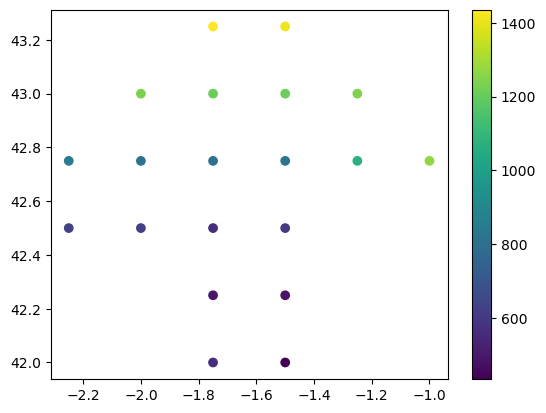

ESPV


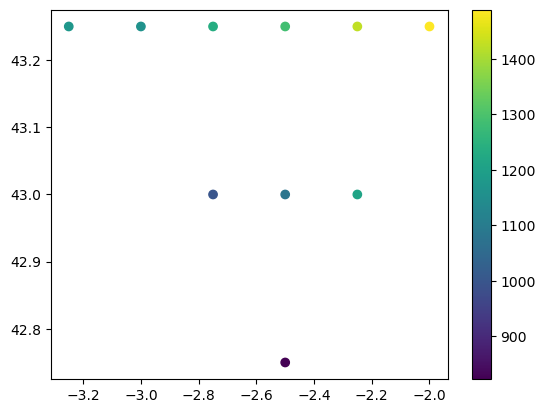

ESRI


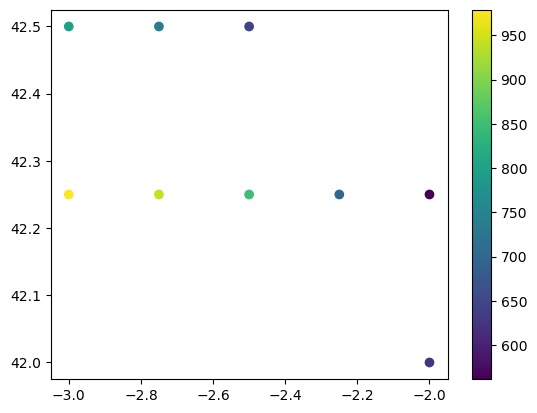

ESCT


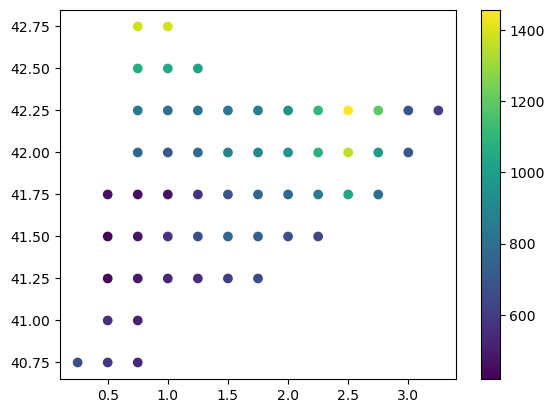

ESAR


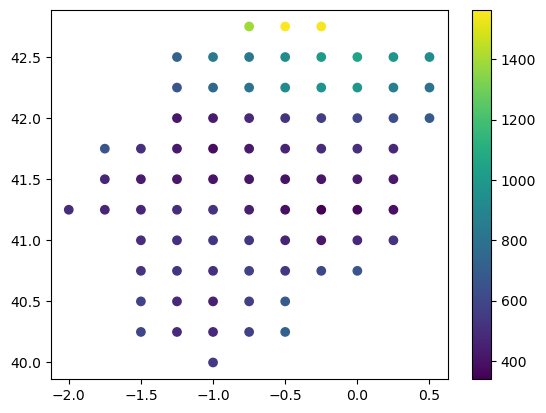

ESEX


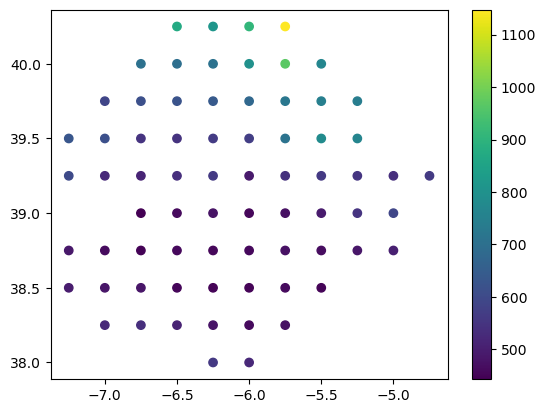

ESGA


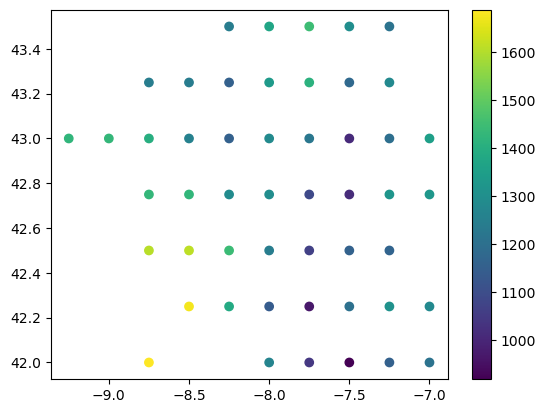

ESCL


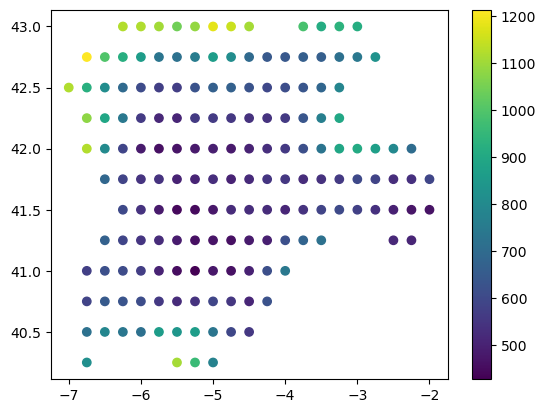

ESVC


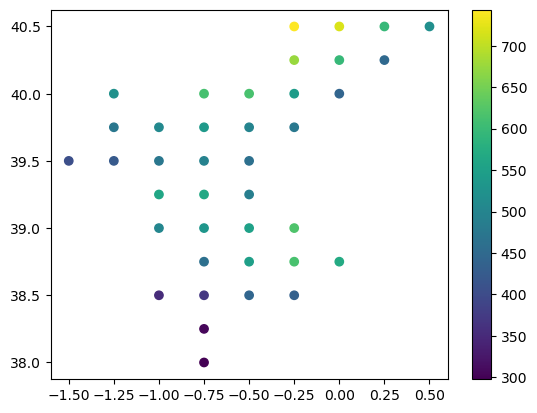

ESMC


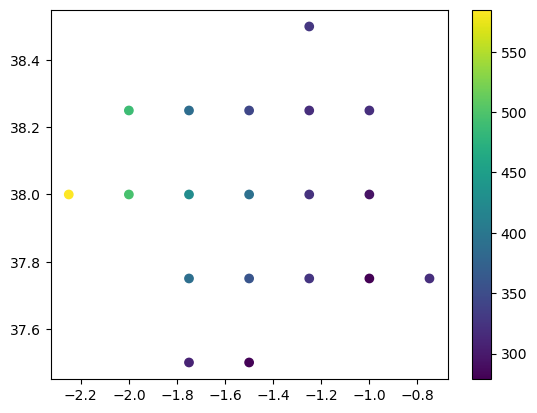

ESAN


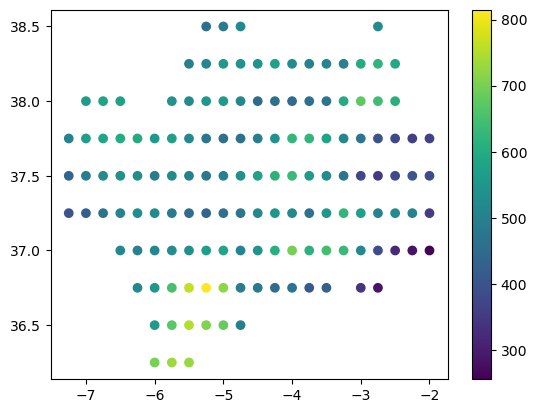

ESAS


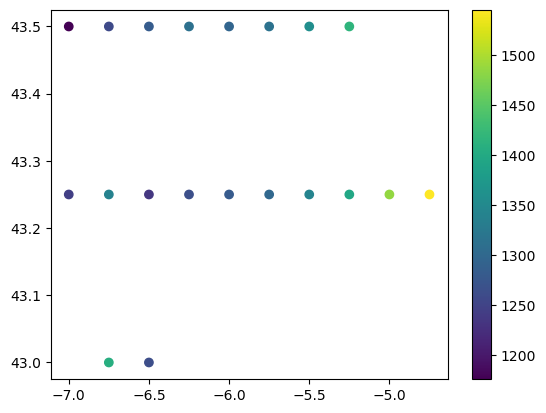

ESCB


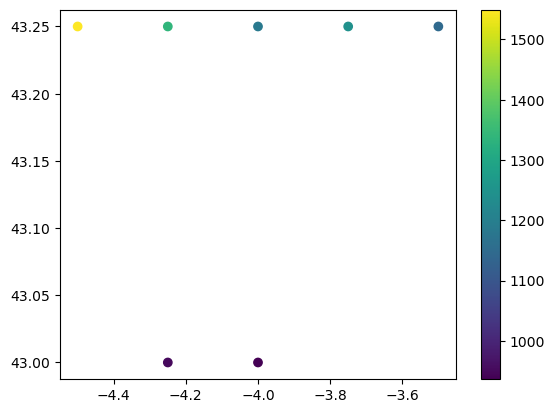

ESCN


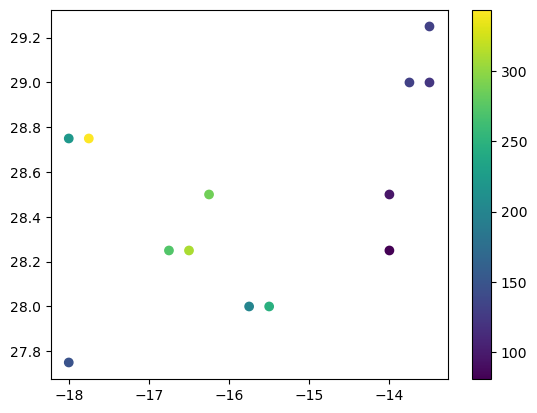

ESIB


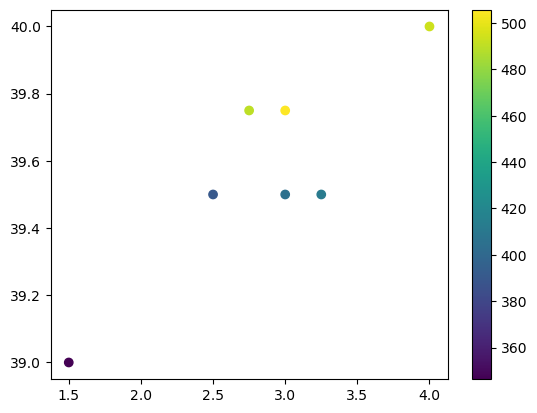

ESCM


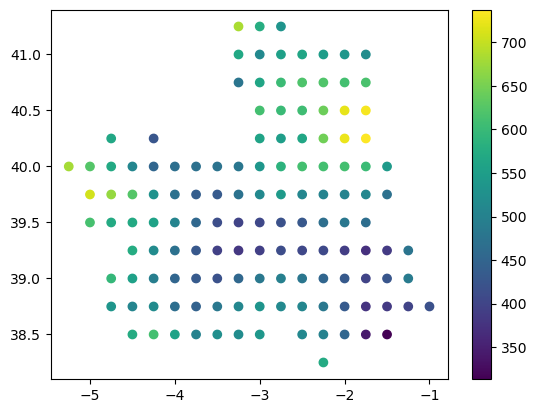

ESMD


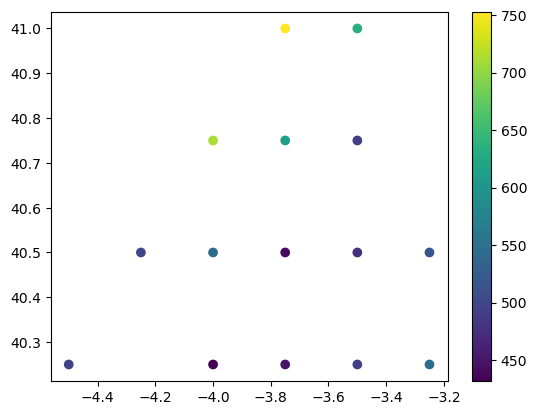

ESCE


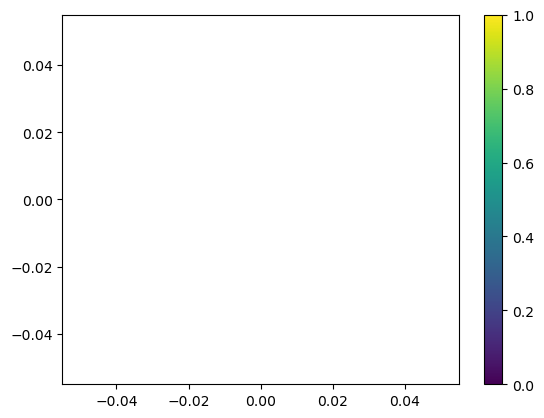

c:\Users\aag23\miniforge3\envs\h5py\Lib\site-packages\numpy\_core\fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\aag23\miniforge3\envs\h5py\Lib\site-packages\numpy\_core\_methods.py:139: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


ESML


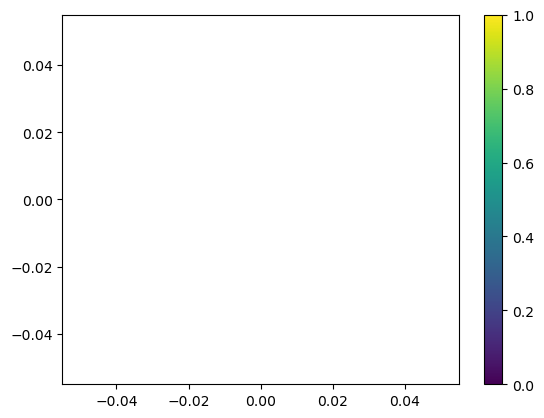

In [167]:
# calculamos la precipitación media por año en cada comunidad autónoma
medias_historicas = []
for i in range(len(gdf_all)):
    # extraemos el poligono de la comunidad autónoma
    gdf_ccaa = gdf_all.iloc[[i]]
    # mostramos el nombre de la comunidad autónoma
    print(gdf_ccaa.id.values[0])

    # calculamos la precipitación media por año en la comunidad autónoma
    total_precipitation_year_ccaa, lon, lat = calculate_total_precipitation(data, gdf_ccaa)
    plt.scatter(lon, lat, c=total_precipitation_year_ccaa.mean(axis=1), cmap='viridis')
    plt.colorbar()
    plt.show()
    # Calculamos la precipitación media por año en cada comunidad autónoma
    # y la guardamos en un DataFrame
    precipitation_mean_ccaa = np.mean(total_precipitation_year_ccaa, axis=0)
    data_serie_ccaa = {'time': years, 'precipitation': precipitation_mean_ccaa}
    df_ccaa = pd.DataFrame(data_serie_ccaa)
    # Guardamos el DataFrame en un fichero csv en dirData,
    # con el nombre que sera el codigo de la comunidad autónoma
    ccaa_name = gdf_ccaa.id.values[0]
    df_ccaa.to_csv(op.join(dirData, f'precipitation_mean_{ccaa_name}.csv'), index=False)
    medias_historicas.append([gdf_ccaa.id.values[0],precipitation_mean_ccaa.mean()])

    

In [169]:
# Mostramos las medias históricas de precipitación en cada comunidad autónoma
# con el nombre de la comunidad autónoma
for ccaa, media in medias_historicas:
    print(info_ccaa[ccaa], media)



Navarra, Comunidad Foral de 887.483899489693
País Vasco 1188.5658575140912
La Rioja 760.0221772124802
Cataluña 782.7604406907153
Aragon 607.9706485336721
Extremadura 581.757937076587
Galicia 1276.948346677034
Castilla y León 665.4922044055063
Comunidad Valenciana 512.6410886196787
Murcia 366.34051608821073
Andalucía 523.7702805062999
Asturias 1325.5885414455247
Cantabria 1192.1120193434058
Islas Canarias 199.24157439266955
Islas Baleares 434.76152716216086
Castilla la Mancha 514.4562418007525
Comunidad de Madrid 538.5373433430991
Ceuta nan
Melilla nan
